<a href="https://colab.research.google.com/github/Shunian-Chen/AIPI510-Project/blob/main/Food_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI510 Project Food Price Prediction

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 1. Data Cleaning

### 1.0 Import Libraries

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import os

### 1.1 Read Data

In [222]:
#Change working directory
PATH = "/content/drive/MyDrive/AIPI510-Project"
os.chdir(PATH)
os.getcwd()

'''
read data into a dictionary
key of the dictionary is the name of dataset
value of the dictionary is the value of that dataset, 
which contains both the date and price
'''
data_path = os.listdir(os.path.join(PATH, "Data"))
data_list = {}
columns = ["close", "value", "dcoilwtico", "usd", "m2"]              #columns that needed for analysis
for path in data_path:
  #read data
  data_path = os.path.join("Data", path)
  data = pd.read_csv(data_path, header = 0)

  #clean the column names
  data.columns = [h.lower().replace(" ", "") for h in data.columns]

  #extract columns needed
  col = ["date"] + data.columns[data.columns.isin(columns)].values.tolist()
  data = data[col]

  #rename the columns
  name = path.split(".")[0]
  data.columns = ["Date", name]

  #transfer datetime
  data["Date"] = pd.to_datetime(data["Date"])
  data.set_index("Date", inplace = True)

  #store the data in a dictory
  data_list[name] = data.copy()

M2 data is stock data, we want to use the change of m2 as a feature

In [200]:
m2 = data_list['M2'].shift(1)
data_list["M2"] =data_list["M2"]  - m2

### 1.2 Null Value Processing

#### 1.2.1 Count null values in each feature

In [201]:
def count_null(data):
  #count null values in each dataframe
  null_values = {"feature":[], "No. null":[]}
  for key, value in data.items():
    null_values["feature"].append(key)
    null_values["No. null"].append(sum(value[key].isna()))
  null_values = pd.DataFrame.from_dict(null_values)
  #visualize null values
  ax = plt.barh(height = 0.6, width = null_values["No. null"], y = null_values["feature"])
  return null_values

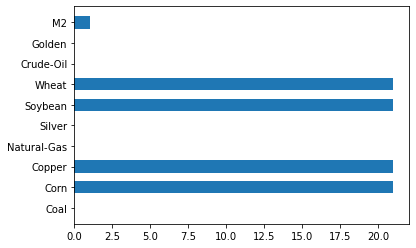

In [202]:
null_count = count_null(data_list)

#### 1.2.2 See how null values distributed in each feature
The results show that all the missing values are actually due to the days haven't arrive, that is, those days haven't really arrive when the data are collected. Therefore, these null values can be directly deleted.

In [203]:
nul_col = null_count[null_count['No. null'] != 0]["feature"]
for col in nul_col:
  print(data_list[col].index[data_list[col][col].isna()])

DatetimeIndex(['2021-11-09', '2021-11-10', '2021-11-11', '2021-11-12',
               '2021-11-13', '2021-11-14', '2021-11-15', '2021-11-16',
               '2021-11-17', '2021-11-18', '2021-11-19', '2021-11-20',
               '2021-11-21', '2021-11-22', '2021-11-23', '2021-11-24',
               '2021-11-25', '2021-11-26', '2021-11-27', '2021-11-28',
               '2021-11-29'],
              dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2021-11-09', '2021-11-10', '2021-11-11', '2021-11-12',
               '2021-11-13', '2021-11-14', '2021-11-15', '2021-11-16',
               '2021-11-17', '2021-11-18', '2021-11-19', '2021-11-20',
               '2021-11-21', '2021-11-22', '2021-11-23', '2021-11-24',
               '2021-11-25', '2021-11-26', '2021-11-27', '2021-11-28',
               '2021-11-29'],
              dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2021-11-09', '2021-11-10', '2021-11-11', '2021-11-12',
               '2021-11-13', '2021-

#### 1.2.3Delete Null Values

In [204]:
data_no_null = {}
for key, value in data_list.items():
  data_no_null[key] = value[~value[key].isna()]

,feature,No. null
0,Coal,0
1,Corn,0
2,Copper,0
3,Natural-Gas,0
4,Silver,0
5,Soybean,0
6,Wheat,0
7,Crude-Oil,0
8,Golden,0
9,M2,0


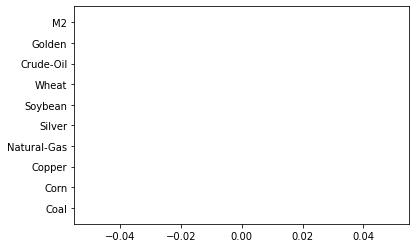

In [205]:
count_null(data_no_null)

### 1.3 Combine Data From Different Source

In [216]:
combo_data = pd.DataFrame()
for key, value in data_no_null.items():
  combo_data = combo_data.merge(value, left_index = True, right_index = True, how = "outer")

For m2, since we only have weekly data, we will use the number of the week to fill out the value in each day within that week

In [217]:
combo_data["M2"] = combo_data["M2"].fillna(method = "ffill")
combo_data

,Coal,Corn,Copper,Natural-Gas,Silver,Soybean,Wheat,Crude-Oil,Golden,M2
Date,,,,,,,,,,
1959-07-01,NaN,1.177,NaN,NaN,NaN,NaN,1.964,NaN,NaN,NaN
1959-07-02,NaN,1.176,0.2930,NaN,NaN,NaN,1.971,NaN,NaN,NaN
1959-07-06,NaN,1.171,0.2910,NaN,NaN,NaN,1.970,NaN,NaN,NaN
1959-07-07,NaN,1.171,0.2820,NaN,NaN,NaN,1.971,NaN,NaN,NaN
1959-07-08,NaN,1.170,0.2846,NaN,NaN,NaN,1.964,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-11-05,148.25,5.530,4.3430,NaN,24.535,12.055,7.665,NaN,"1,801.90",-1.8
2021-11-06,NaN,NaN,NaN,NaN,24.535,NaN,NaN,NaN,NaN,-1.8
2021-11-07,NaN,NaN,NaN,NaN,24.175,NaN,NaN,NaN,NaN,-1.8


Then we only choose those days all feature are avaiable

In [212]:
combo_data.dropna(axis = 0, how = 'any')

,Coal,Corn,Copper,Natural-Gas,Silver,Soybean,Wheat,Crude-Oil,Golden,M2
Date,,,,,,,,,,
2009-09-01,68.25,3.1925,2.8185,4.13,15.00750,9.5550,4.8725,68.11,955,4.7
2009-10-01,71.20,3.4050,2.7370,5.22,16.41000,9.1800,4.5275,70.67,"1,004.80",-2.8
2009-12-01,77.50,4.1450,3.2135,7.39,19.12500,10.5950,5.8400,78.39,"1,192.50",-0.1
2010-02-01,79.15,3.5900,3.0835,6.03,16.63750,9.0975,4.7475,74.41,"1,086.50",14.5
2010-03-01,76.75,3.8175,3.3500,4.95,16.47250,9.6250,5.0450,78.71,"1,114.00",-12.6
...,...,...,...,...,...,...,...,...,...,...
2021-06-01,95.80,6.8875,4.6535,3.83,27.88625,15.4850,6.9350,67.8,"1,899.40",-1.8
2021-07-01,122.25,6.0175,4.2360,3.96,26.02375,14.2975,6.6550,75.33,"1,781.50",-1.8
2021-09-01,156.25,5.2275,4.2780,5.58,24.16525,12.7775,7.1425,68.63,"1,811.80",-1.8


### 1.4 Outlier Dection

### 1.5 Food Price Index Calculation

### 1.6 Data Normalization

### 1.7 Feature Selection

## 2. Model Fitting

## 3. Result Presentation